In [70]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Finance_Stock_Crypto_Trading/Credit_Suisse_Price_Prediction_with_GRU/OUTPUT.ipynb

In [71]:
df = pd.read_csv('NFLX.csv')
df
df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
df.head()

,date,open,high,low,close,adj_close,volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [72]:
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])

Total number of days:  1009
Total number of fields:  7


In [73]:
print("Null values:", df.isnull().values.sum())
print("NA values:", df.isna().values.any())

Null values: 0
NA values: False


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1009 non-null   object 
 1   open       1009 non-null   float64
 2   high       1009 non-null   float64
 3   low        1009 non-null   float64
 4   close      1009 non-null   float64
 5   adj_close  1009 non-null   float64
 6   volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [75]:
df['date'] = pd.to_datetime(df['date'], utc=True)


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1009 non-null   datetime64[ns, UTC]
 1   open       1009 non-null   float64            
 2   high       1009 non-null   float64            
 3   low        1009 non-null   float64            
 4   close      1009 non-null   float64            
 5   adj_close  1009 non-null   float64            
 6   volume     1009 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 55.3 KB


In [77]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2018-02-05 00:00:00+00:00
Ending date:  2022-02-04 00:00:00+00:00
Duration:  1460 days 00:00:00


In [78]:
df_close = df[['date','close']]

df_close_original = df_close.copy()

print("Shape of close dataframe:", df_close.shape)
df_close

Shape of close dataframe: (1009, 2)


,date,close
0,2018-02-05 00:00:00+00:00,254.259995
1,2018-02-06 00:00:00+00:00,265.720001
2,2018-02-07 00:00:00+00:00,264.559998
3,2018-02-08 00:00:00+00:00,250.100006
4,2018-02-09 00:00:00+00:00,249.470001
...,...,...
1004,2022-01-31 00:00:00+00:00,427.140015
1005,2022-02-01 00:00:00+00:00,457.130005
1006,2022-02-02 00:00:00+00:00,429.480011
1007,2022-02-03 00:00:00+00:00,405.600006


In [79]:
training_size=int(len(df_close)*0.80)

test_size=len(df_close)-training_size

train_data,test_data = df_close[0:training_size],df_close[training_size:len(df_close)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

train_data:  (807, 2)
test_data:  (202, 2)


In [80]:

del train_data['date']
del test_data['date']

In [81]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(df_close.shape)


time_step = 15

(1009, 2)


In [82]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [83]:

X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

for i in range(15):
    print(X_train[i][:5],y_train[i])


X_train:  (791, 15)
y_train:  (791,)
X_test:  (186, 15)
y_test (186,)
[0.05782213 0.09033648 0.08704531 0.04601941 0.04423196] 0.16095436775521732
[0.09033648 0.08704531 0.04601941 0.04423196 0.06829145] 0.16313906942898615
[0.08704531 0.04601941 0.04423196 0.06829145 0.06919929] 0.16033026860561217
[0.04601941 0.04423196 0.06829145 0.06919929 0.09113089] 0.19057475687270986
[0.04423196 0.06829145 0.06919929 0.09113089 0.13161772] 0.2301537477632002
[0.06829145 0.06919929 0.09113089 0.13161772 0.12665262] 0.2591499469406491
[0.06919929 0.09113089 0.13161772 0.12665262 0.12673773] 0.24763091854996255
[0.09113089 0.13161772 0.12665262 0.12673773 0.13380242] 0.23582815017812142
[0.13161772 0.12665262 0.12673773 0.13380242 0.12557455] 0.2767973412882553
[0.12665262 0.12673773 0.13380242 0.12557455 0.14767629] 0.24802808132378762
[0.12673773 0.13380242 0.12557455 0.14767629 0.17102649] 0.23265049901177148
[0.13380242 0.12557455 0.14767629 0.17102649 0.16095437] 0.24873738162565273
[0.125574

In [84]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [86]:
epochs= 100
batch_size = 16
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

Epoch 1/100
50/50 [==============================] - 3s 9ms/step - loss: 0.0495
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 8/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 9/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 10/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 11/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 12/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 13/100
50/50 [=================

In [87]:
# test_predict=model.predict(X_test[-time_step:])
# print(X_test[-1])
# print("-----------------------------")
# print(X_test[-2:])
# print("-----------------------------")
# print(test_predict)

In [88]:

predictions = []

last_prices = X_train#[-time_step:]
for i in range(test_data.shape[0]):
    temp_row = time_step*[0]

    for i in range(time_step-1):
        temp_row[i] = last_prices[-1][i+1]


    prediction= model.predict(last_prices[-time_step:])[0,0] #last_prices[-15:]
    temp_row[-1] = prediction
    predictions.append(prediction)

    last_prices = np.vstack((last_prices,temp_row))

# print(temp_row)
# print(last_prices)
print(predictions)

1/1 [==============================] - 0s 14ms/step
[0.7510469, 0.76534957, 0.7657423, 0.7849482, 0.82711875, 0.83393025, 0.84343535, 0.84987855, 0.86745757, 0.87093174, 0.86602616, 0.86800104, 0.8374853, 0.8555031, 0.8511618, 0.74169874, 0.7420391, 0.74220467, 0.7579787, 0.79390574, 0.8028126, 0.8110168, 0.8166331, 0.83087087, 0.8348936, 0.8314833, 0.8328282, 0.80867994, 0.82083726, 0.8184928, 0.730045, 0.72106016, 0.72027755, 0.73327625, 0.76407033, 0.7742994, 0.78160185, 0.78650355, 0.79810804, 0.80234927, 0.8000632, 0.80098253, 0.78173673, 0.78968745, 0.7886346, 0.71688044, 0.7018827, 0.69979644, 0.7104858, 0.7370197, 0.74802005, 0.7547073, 0.75899774, 0.7684982, 0.77273846, 0.77130234, 0.7719366, 0.75650036, 0.7614318, 0.7611795, 0.70276445, 0.6841179, 0.68061095, 0.68932974, 0.7122984, 0.7236786, 0.72995627, 0.733732, 0.7415321, 0.7456273, 0.74483365, 0.7452803, 0.732829, 0.7356005, 0.7358095, 0.68810785, 0.6674902, 0.66259515, 0.66959685, 0.68955696, 0.7010399, 0.7070538, 0.7104

In [89]:
predictions_array = np.array(predictions)
predictions_reshaped = predictions_array.reshape(-1,1)
predicted_prices = scaler.inverse_transform(predictions_reshaped)
predicted_prices

array([[498.59402],
       [503.63513],
       [503.77356],
       [510.5429 ],
       [525.4063 ],
       [527.80707],
       [531.1572 ],
       [533.4282 ],
       [539.62415],
       [540.84863],
       [539.1196 ],
       [539.8157 ],
       [529.0601 ],
       [535.41064],
       [533.8805 ],
       [495.29916],
       [495.41913],
       [495.4775 ],
       [501.0372 ],
       [513.7001 ],
       [516.83936],
       [519.731  ],
       [521.7106 ],
       [526.72876],
       [528.1466 ],
       [526.94464],
       [527.41864],
       [518.90735],
       [523.1923 ],
       [522.366  ],
       [491.19168],
       [488.0249 ],
       [487.74905],
       [492.3306 ],
       [503.18423],
       [506.7896 ],
       [509.3634 ],
       [511.0911 ],
       [515.18115],
       [516.676  ],
       [515.8703 ],
       [516.19434],
       [509.41098],
       [512.21326],
       [511.84216],
       [486.55173],
       [481.26562],
       [480.5303 ],
       [484.29788],
       [493.65   ],


In [90]:
test_prices = scaler.inverse_transform(test_data)
train_prices = scaler.inverse_transform(train_data)
test_prices

array([[508.899994],
       [508.779999],
       [505.549988],
       [510.299988],
       [505.549988],
       [506.519989],
       [509.      ],
       [513.469971],
       [509.109985],
       [503.179993],
       [496.079987],
       [499.549988],
       [503.839996],
       [486.690002],
       [495.079987],
       [484.980011],
       [486.660004],
       [493.369995],
       [488.940002],
       [486.279999],
       [487.700012],
       [501.670013],
       [497.890015],
       [502.899994],
       [501.339996],
       [502.359985],
       [503.859985],
       [502.809998],
       [499.079987],
       [499.23999 ],
       [489.429993],
       [494.73999 ],
       [494.660004],
       [492.390015],
       [485.809998],
       [487.269989],
       [488.769989],
       [499.890015],
       [491.899994],
       [492.410004],
       [498.339996],
       [500.769989],
       [497.      ],
       [508.820007],
       [512.73999 ],
       [518.059998],
       [527.070007],
       [533.0

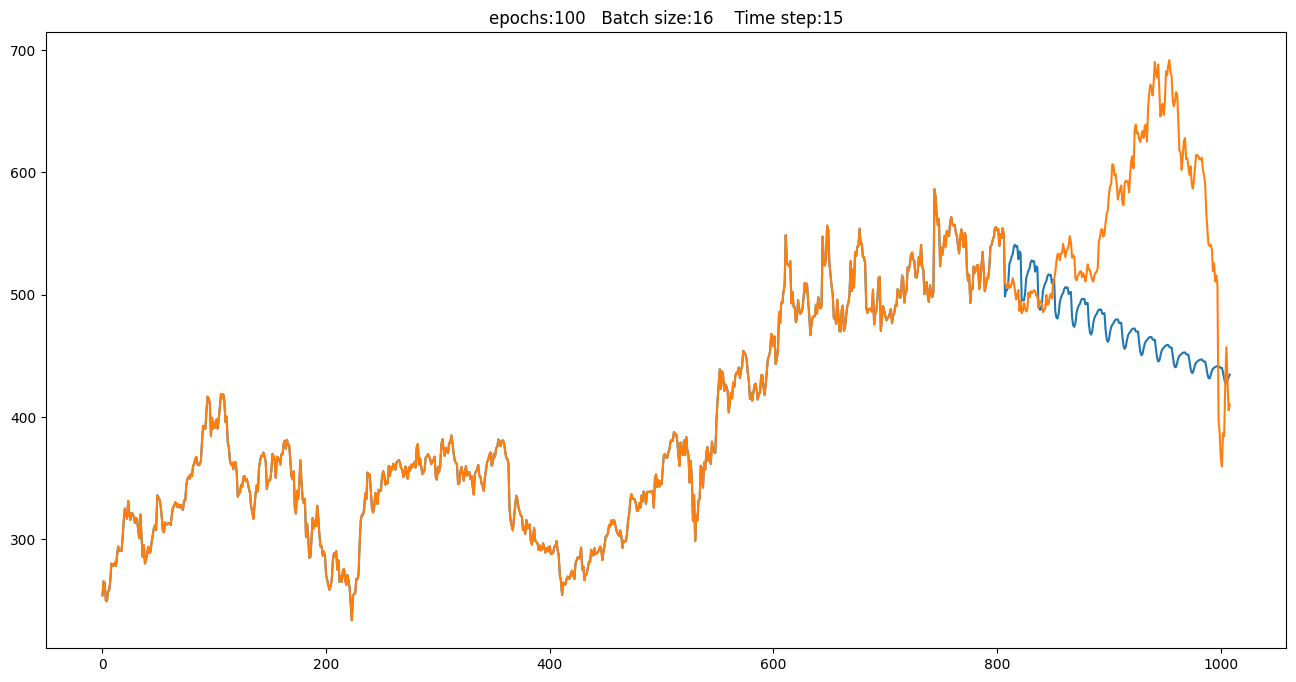

In [91]:
import matplotlib.pyplot as plt

# plt.plot(train_prices+predicted_prices)
# plt.plot(train_prices+test_prices)
plt.figure(figsize = (16,8))
plt.plot(np.vstack((train_prices,predicted_prices)))
plt.plot(np.vstack((train_prices,test_prices)))
title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step)
plt.title(title)
plt.show()

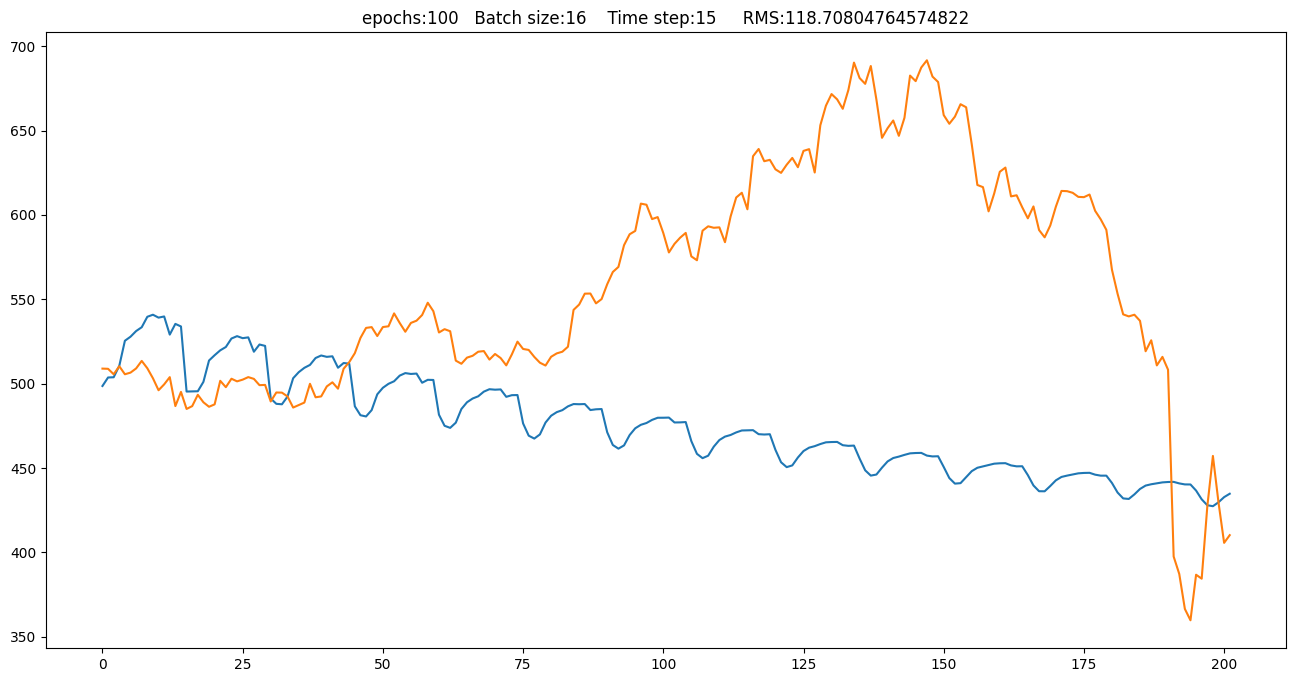

In [92]:
plt.figure(figsize = (16,8))
plt.plot(np.vstack((predicted_prices)))
plt.plot(np.vstack((test_prices)))
rms =  math.sqrt(mean_squared_error(test_prices,predicted_prices))

title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step) +"     RMS:"+str(rms)
plt.title(title)
plt.show()